             track_id                                   user_id  playcount  \
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   

   most_played_cluster  
0                    2  
1                    2  
2                    2  
3                    2  
4                    2  


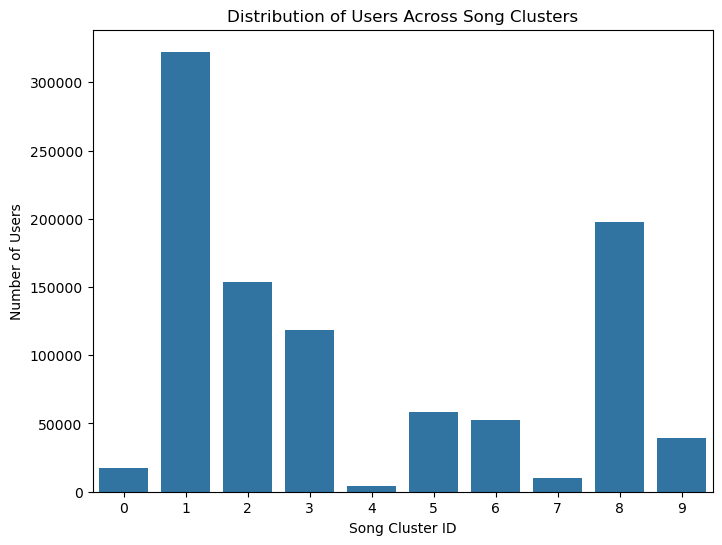

In [44]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

# Load data
file_path_users = "Data/User Listening History.csv"
df_users = pd.read_csv(file_path_users)
file_path_songs = "Data/Music Info.csv"
df_songs = pd.read_csv(file_path_songs)

song_features = ['duration_ms', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 
                    'tempo', 'time_signature']
song_data = df_songs[song_features]

# Normalize the song features
scaler = StandardScaler()
scaled_songs = scaler.fit_transform(song_data)

# Apply KMeans clustering to the songs
n_song_clusters = 10  # Choose an appropriate number of clusters
kmeans_songs = KMeans(n_clusters=n_song_clusters, random_state=42)
df_songs['song_cluster'] = kmeans_songs.fit_predict(scaled_songs)

df_users = df_users.merge(df_songs[['track_id', 'song_cluster']], on='track_id', how='left')

# Group by user and song cluster, and sum the playcount
user_cluster_plays = df_users.groupby(['user_id', 'song_cluster'])['playcount'].sum().reset_index()

# Pivot to create a matrix of users vs. song clusters
user_cluster_matrix = user_cluster_plays.pivot(index='user_id', columns='song_cluster', values='playcount').fillna(0)

# Find the song cluster with the maximum playcount for each user
user_cluster_matrix['most_played_cluster'] = user_cluster_matrix.idxmax(axis=1)

df_users = df_users.merge(user_cluster_matrix['most_played_cluster'], on='user_id', how='left')

df_users = df_users.drop(columns=['song_cluster'], axis=1)

# Print the resulting user dataset with clusters
print(df_users.head())

plt.figure(figsize=(8, 6))
sns.countplot(x='most_played_cluster', data=user_cluster_matrix.reset_index())
plt.title('Distribution of Users Across Song Clusters')
plt.xlabel('Song Cluster ID')
plt.ylabel('Number of Users')
plt.show()

most_played_cluster
2    250438
8    235510
3    146783
6     93591
9     57981
5     55380
0     43631
1     43352
7     23760
4     11611
Name: count, dtype: int64


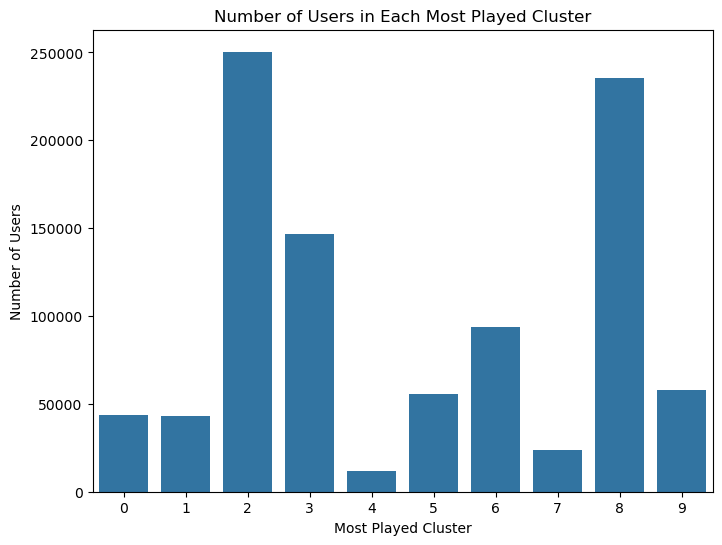

In [23]:
# Count the number of users in each most_played_cluster
cluster_counts = user_cluster_matrix['most_played_cluster'].value_counts()

# Print the results
print(cluster_counts)

# Optional: Visualize the counts with a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Number of Users in Each Most Played Cluster')
plt.xlabel('Most Played Cluster')
plt.ylabel('Number of Users')
plt.show()

In [25]:
# Create a DataFrame for cluster centroids
centroid_df = pd.DataFrame(kmeans_songs.cluster_centers_, columns=song_features)

# Add a cluster ID column for reference
centroid_df['Cluster ID'] = centroid_df.index

# Print or display the centroids
print(centroid_df)

# Analyze top features for each cluster
for cluster_id in range(len(centroid_df)):
    print(f"\nCluster {cluster_id} Characteristics:")
    cluster_features = centroid_df.loc[cluster_id, song_features]
    print(cluster_features.sort_values(ascending=False).head(5))  # Top 5 highest features
    print(cluster_features.sort_values(ascending=True).head(5))   # Top 5 lowest features

   duration_ms  danceability    energy       key  loudness      mode  \
0     0.094589     -0.332988  0.473550 -0.007440  0.229581  0.040451   
1    -0.252404      0.723119  0.067917  0.058864  0.074277 -0.025731   
2    -0.136793     -0.503351  0.629236 -0.109789  0.606599  0.764615   
3    -0.104313      0.952831  0.040884  0.362997  0.129145 -1.307848   
4     3.362888     -0.519260 -0.284055  0.065220 -0.479308 -0.139186   
5     0.197511     -0.240067  0.405068  0.009505  0.116522  0.025366   
6    -0.195809     -0.235752 -1.582324 -0.050443 -1.374119  0.060898   
7    -0.173982     -0.625323 -1.364887 -0.070234 -1.170954  0.045770   
8    -0.268353      0.831613  0.018239 -0.164251  0.124055  0.764615   
9    -0.025840     -0.524383  0.655025  0.135772  0.600671 -1.307848   

   speechiness  acousticness  instrumentalness  liveness   valence     tempo  \
0     0.140589     -0.252632         -0.134834  2.954559 -0.096034 -0.000211   
1     3.699966     -0.035047         -0.356939 

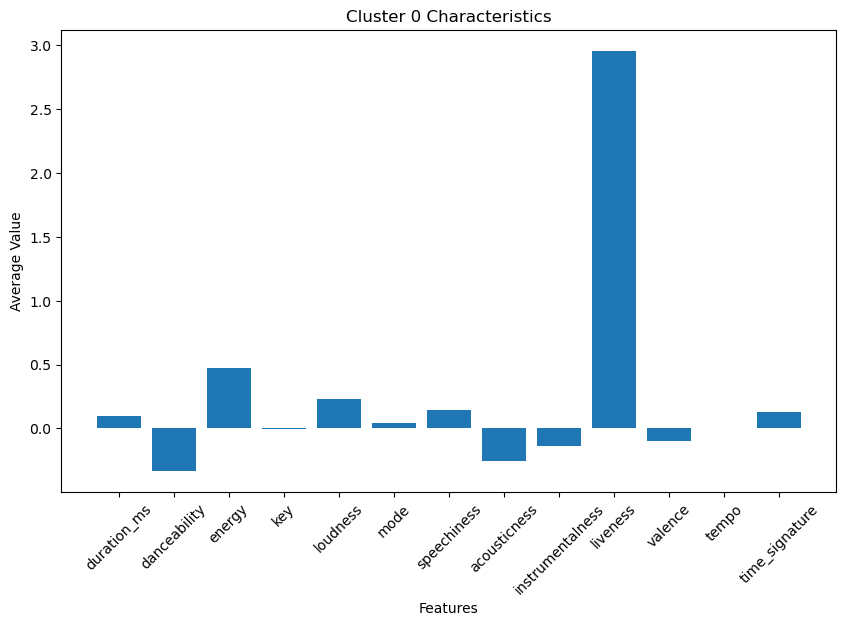

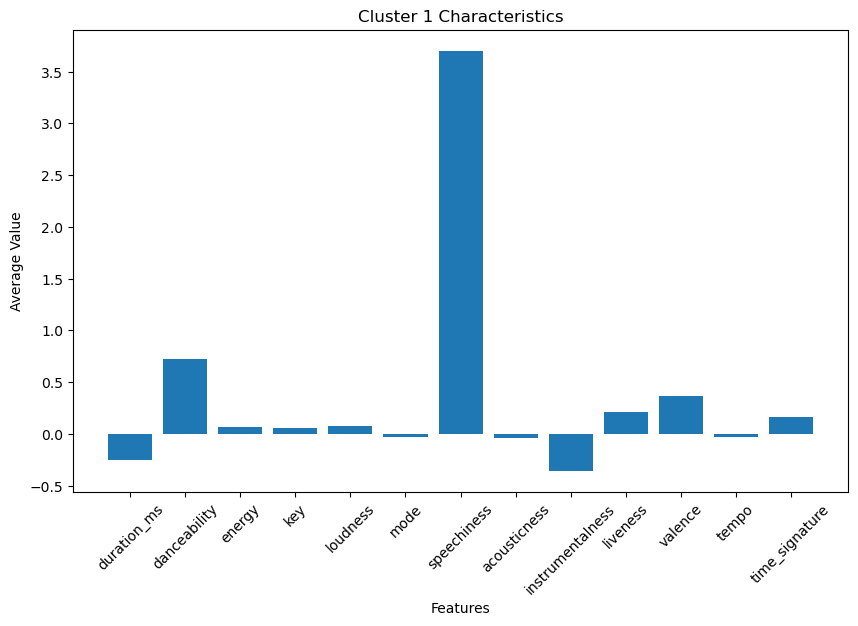

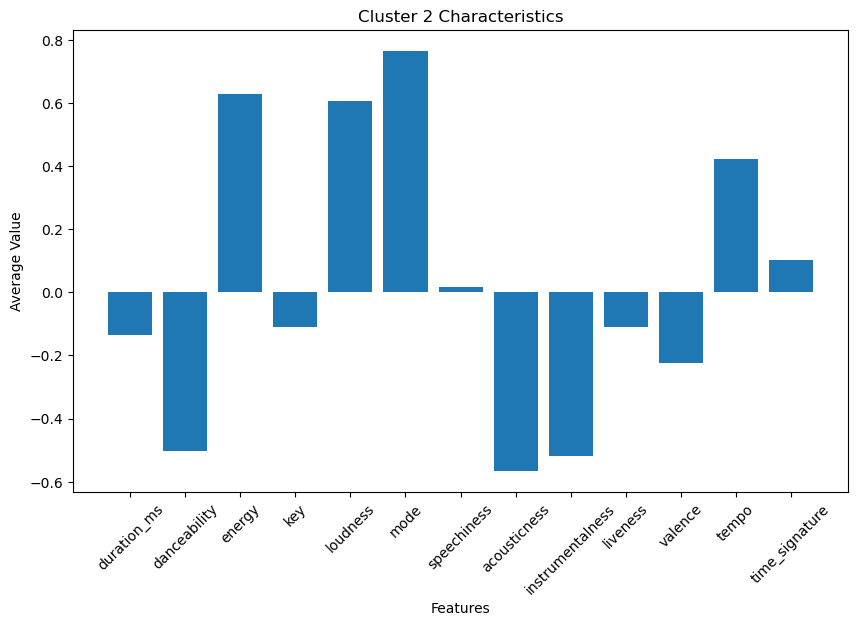

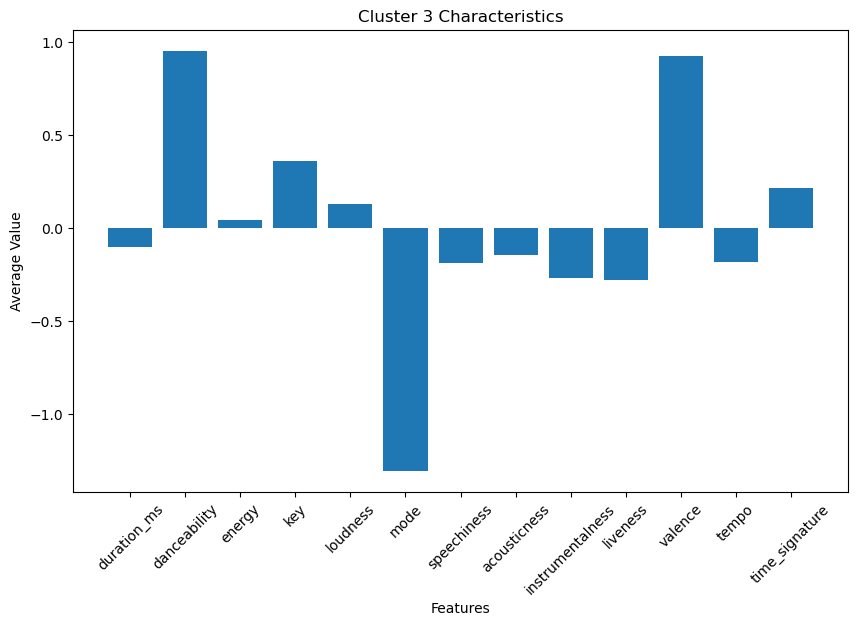

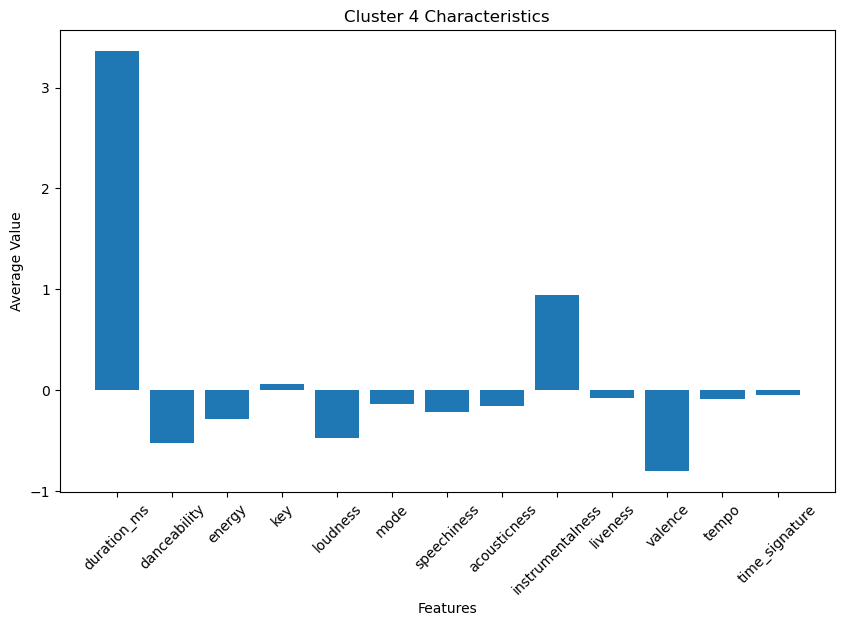

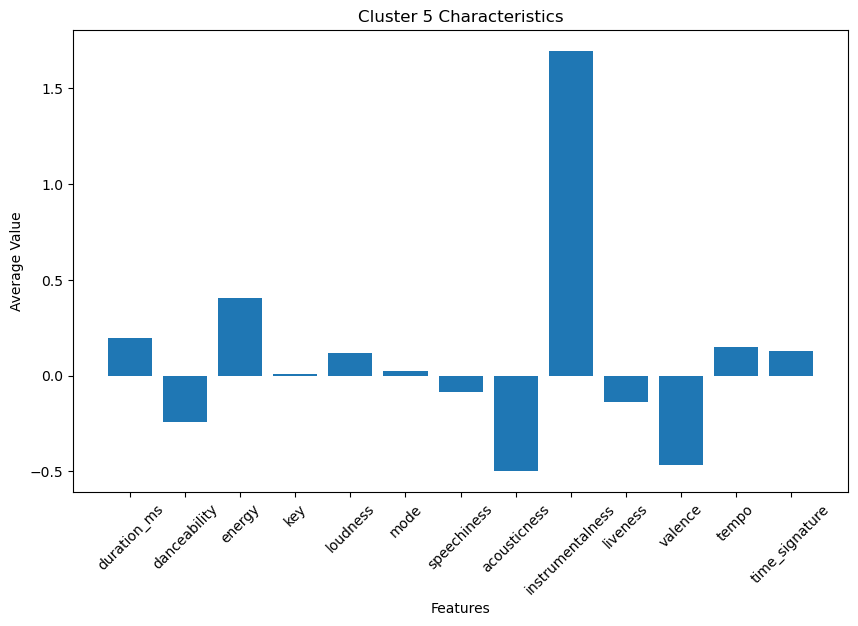

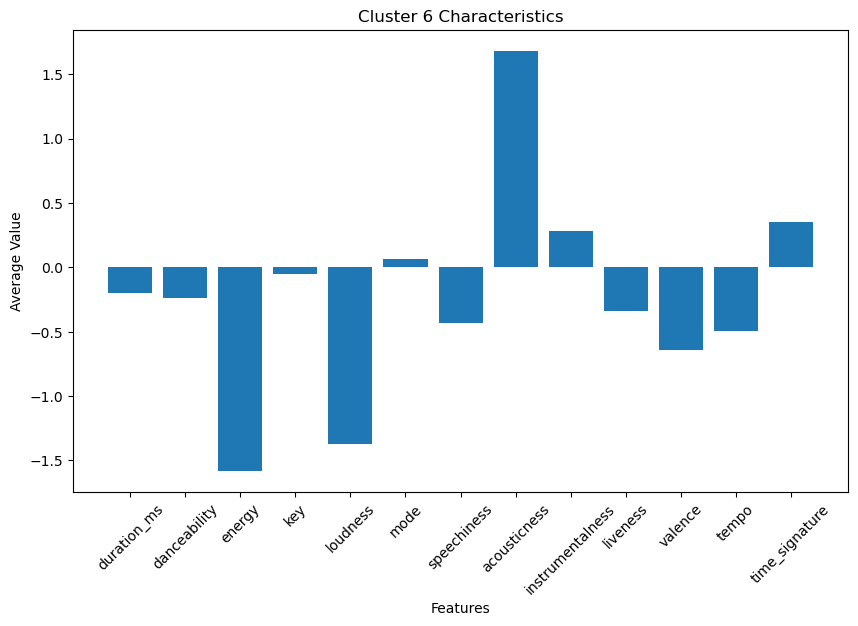

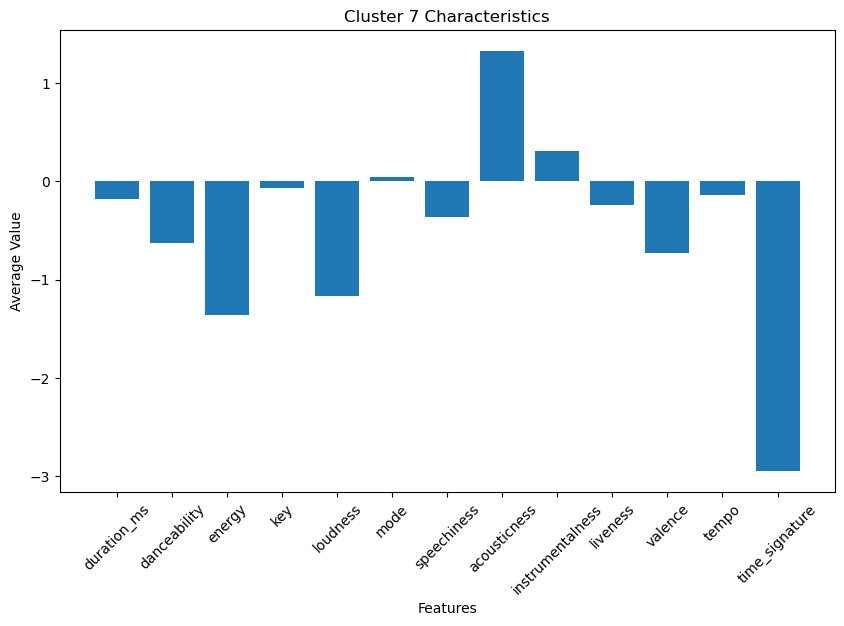

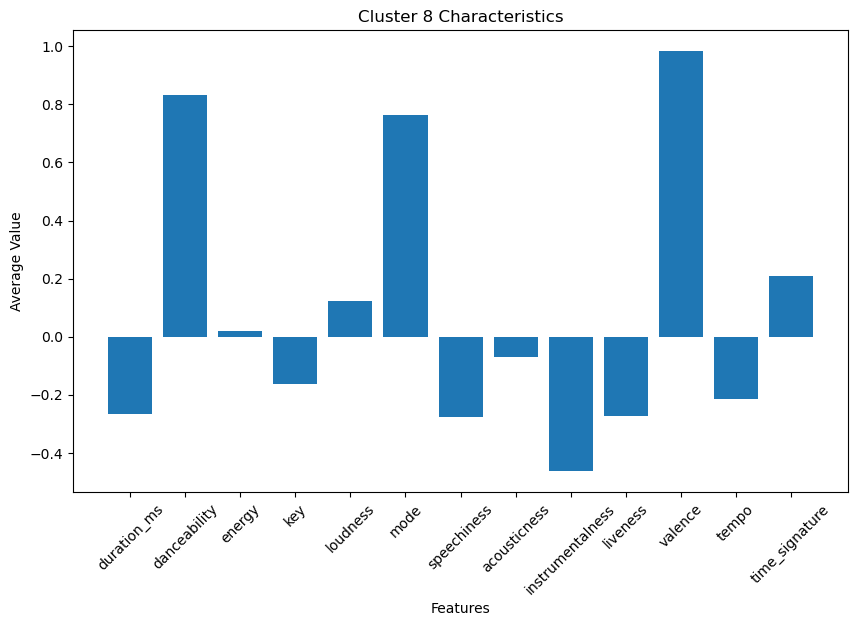

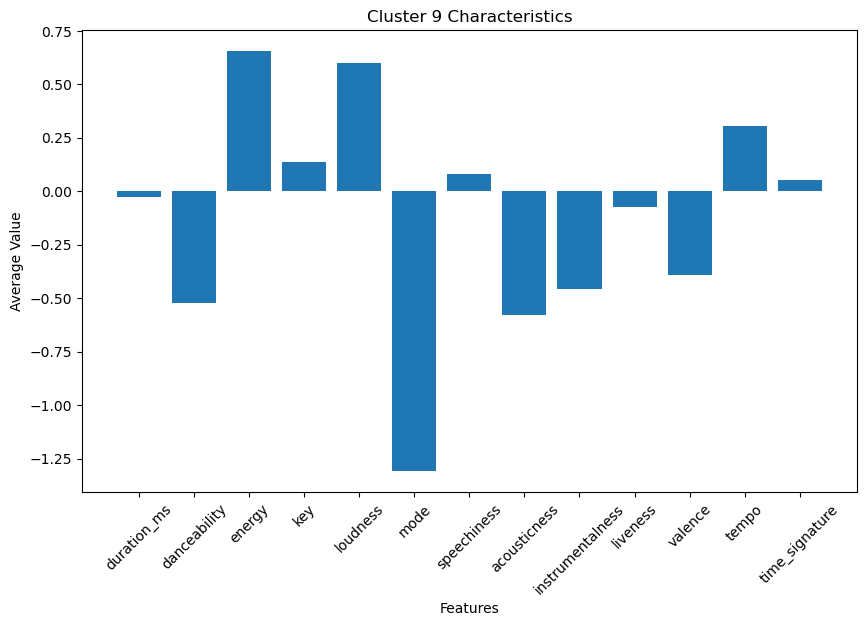

In [26]:
# Plot each cluster centroid as a bar chart
for cluster_id in range(len(centroid_df)):
    plt.figure(figsize=(10, 6))
    plt.bar(song_features, centroid_df.loc[cluster_id, song_features])
    plt.title(f"Cluster {cluster_id} Characteristics")
    plt.xlabel("Features")
    plt.ylabel("Average Value")
    plt.xticks(rotation=45)
    plt.show()

In [30]:
from scipy.spatial.distance import cdist

# Compute distances from each song to its cluster centroid
song_features_matrix = scaled_songs  # Normalized feature matrix
cluster_centers = kmeans_songs.cluster_centers_

# Compute distances between songs and their assigned cluster centers
distances = cdist(song_features_matrix, cluster_centers, metric='euclidean')

# Add distances to the original DataFrame
df_songs['distance_to_centroid'] = [
    distances[i, cluster_id] for i, cluster_id in enumerate(df_songs['song_cluster'])
]

# Find representative songs for each cluster
representative_songs = {}
for cluster_id in range(n_song_clusters):
    # Filter songs belonging to the cluster and sort by distance to the centroid
    cluster_songs = df_songs[df_songs['song_cluster'] == cluster_id]
    top_songs = cluster_songs.nsmallest(5, 'distance_to_centroid')  # Top 5 closest songs
    representative_songs[cluster_id] = top_songs[['track_id', 'name', 'artist', 'genre', 'distance_to_centroid']]

# Print representative songs for each cluster
for cluster_id, songs in representative_songs.items():
    print(f"\nCluster {cluster_id} Representative Songs:")
    print(songs)


Cluster 0 Representative Songs:
                 track_id                name               artist  genre  \
17508  TRZJDVO128F1477600        Lost in Love           Air Supply    NaN   
2322   TRXWBRB128F931C962  Summertime Clothes    Animal Collective    NaN   
35434  TRAUUUQ128F92E330B     Counterfeit God  Black Label Society  Metal   
17756  TRAXMGO128F422F673       Stone in Love              Journey   Rock   
41715  TRLDUML128F931C2E0          Toxic Dart         Jaga Jazzist   Jazz   

       distance_to_centroid  
17508              1.316677  
2322               1.386646  
35434              1.417892  
17756              1.436858  
41715              1.453086  

Cluster 1 Representative Songs:
                 track_id                   name      artist       genre  \
21442  TRVYHQK128F4233819           Arcade Robot  Boys Noize  Electronic   
29555  TRFIOBS128F9335325          Mommy Complex     Peaches  Electronic   
45046  TRAZIHK12903CCC449        Wipe Your Tears  Mistabishi  E

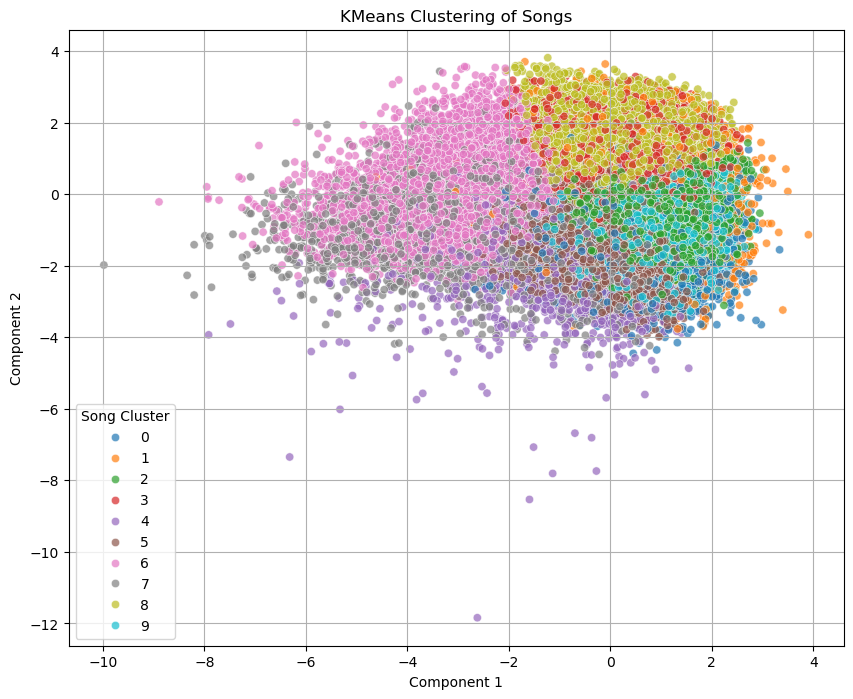

In [31]:
# Plot the clusters

# Apply KMeans clustering to the songs
n_song_clusters = 10  # Choose an appropriate number of clusters
kmeans_songs = KMeans(n_clusters=n_song_clusters, random_state=42)
df_songs['song_cluster'] = kmeans_songs.fit_predict(scaled_songs)

# Reduce to 2D for visualization
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_features = svd.fit_transform(scaled_songs)

# Create a DataFrame for visualization
cluster_vis_df = pd.DataFrame(reduced_features, columns=['Component 1', 'Component 2'])
cluster_vis_df['Cluster'] = df_songs['song_cluster']

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=cluster_vis_df, 
    x='Component 1', 
    y='Component 2', 
    hue='Cluster', 
    palette='tab10', 
    alpha=0.7
)
plt.title('KMeans Clustering of Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Song Cluster', loc='best')
plt.grid(True)
plt.show()

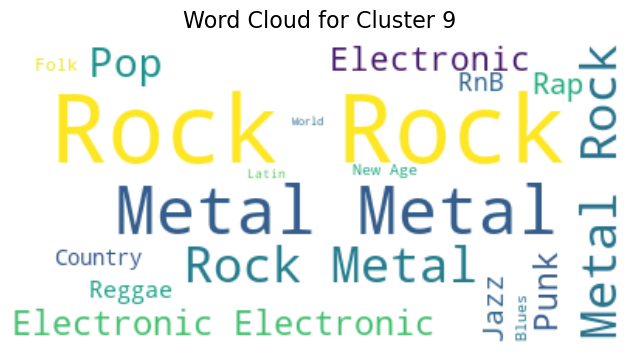

In [43]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Function to generate and display word clouds for a specific cluster
def generate_word_cloud(cluster_id, column):
    # Filter songs in the given cluster
    cluster_songs = df_songs[df_songs['song_cluster'] == cluster_id]
    
    # Combine all text data from the specified column (e.g., 'genre' or 'name')
    text_data = " ".join(cluster_songs[column].dropna())
    
    # Preprocess: Add stopwords if needed
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_data)
    
    # Display the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Cluster {cluster_id}", fontsize=16)
    plt.axis("off")
    plt.show()

# Example: Generate word cloud for cluster 6
generate_word_cloud(cluster_id=9, column='genre')